In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline 
import numpy as np
import scipy as sp

def read_file( filename, n ):
    with open( filename, mode = 'r' ) as inputfile:
        lines = inputfile.readlines()

    lists = [ [] for i in range(n) ] 
    for line in lines:
        data = line.split(';')
        if '#' not in line and len(line.split()) > 0:
            for i, l in zip(range(n), lists):
                l.append( float(data[i]) )

    return lists 

def celcius_to_kelvin( temp ):
    return [ t + 273.15 for t in temp ]

def calc_alpha( mass ):
    total_diff = mass[-1] - mass[0]
    return [ (m - mass[0])/total_diff for m in mass]

def plot( x, y, spl ):
    fig = plt.figure()
    
    plt.scatter( x, y, s = 2, color = 'k' )
    
    xlin = np.linspace( min(x), max(x), 500 )
    ylin = spl(xlin)
    plt.plot( xlin, ylin, color = 'r', lw = 2.0 )
    
    plt.grid(linestyle = ':', alpha = 0.7)
    plt.show()

**Читаем файлы; переводим температуру в Кельвины; переходим к степени превращения**

In [2]:
temperature1, time1, mass1, dtg1 = read_file('./ExpDat_00089_CaC2O4_5_30-300_Al2O3-lids_Air-30-10_TGA.txt', 4)
temperature2, time2, mass2, dtg2 = read_file('./ExpDat_00089_CaC2O4_10_30-300_Al2O3-lids_Air-30-10_TGA.txt', 4)
temperature3, time3, mass3, dtg3 = read_file('./ExpDat_00089_CaC2O4_20_30-300_Al2O3-lids_Air-30-10_TGA.txt', 4)

temperature1 = celcius_to_kelvin( temperature1 )
temperature2 = celcius_to_kelvin( temperature2 )
temperature3 = celcius_to_kelvin( temperature3 )

alpha1 = calc_alpha(mass1)
alpha2 = calc_alpha(mass2)
alpha3 = calc_alpha(mass3)

alphas = [ alpha1, alpha2, alpha3 ]
temperatures = [ temperature1, temperature2, temperature3 ]
times = [ time1, time2, time3 ]

**Собираем функции для сглаживания сплайном alpha(t); расчета обратной температуры при заданной степени превращения; расчета логарифма производной степени превращения по времени при заданной степени превращения**

[64.113931562526389, 104.42435434990044, 87.090879412910652, 90.704662707307477, 78.699851638001363, 77.486058631006188, 72.193213903438703, 63.336562037263469, 57.174871323427688, 64.801341011091964]


<IPython.core.display.Javascript object>


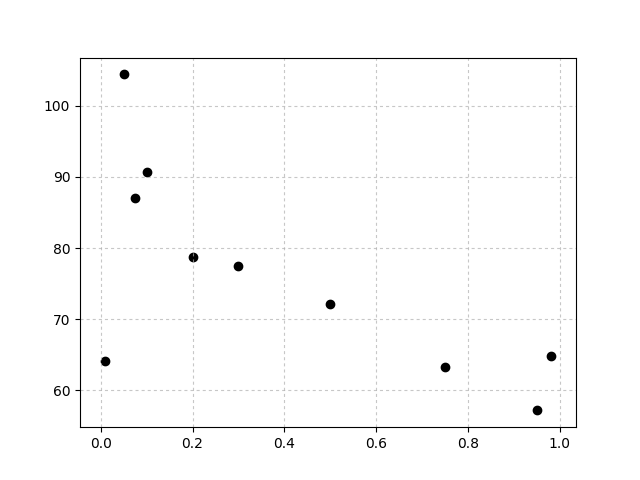

In [3]:
def calculate_alpha_derivative( time, alpha, alpha_value ):
    spl = UnivariateSpline( time, alpha, k = 3, s = 0 )
    spl_der = spl.derivative()
    
    closest_alpha = min(alpha, key = lambda a: abs(a - alpha_value))
    #print('closest_alpha: {0}'.format(closest_alpha))
    index = alpha.index(closest_alpha)
    time_value = time[index]
    
    der = spl_der( time_value )
    #print('derivative: {0}'.format(der))
    return der

def calculate_inverse_temperature( temperature, alpha, alpha_value ):
    closest_alpha = min(alpha, key = lambda a: abs(a - alpha_value))
    #print('closest_alpha:{0}'.format(closest_alpha))
    index = alpha.index(closest_alpha)
    temperature_value = temperature[index]
    #print('temperature: {0}'.format(temperature_value))
    return 1000.0 / temperature_value

def collect_data_different_speeds( alphas, times, temperatures, alpha_value ):
    lhs = [] # 1000 / T
    rhs = [] # logarithm of derivatives
    
    for alpha, time, temperature in zip(alphas, times, temperatures):
        derivative = calculate_alpha_derivative(time, alpha, alpha_value)
        rhs.append( np.log(derivative) )
        
        inverse_temperature = calculate_inverse_temperature(temperature, alpha, alpha_value)
        lhs.append( inverse_temperature )
        
    return lhs, rhs

def summary( alphas, times, temperatures, alpha_values ):
    lhs_lists, rhs_lists = [], []
    k_values = []
    for alpha_value in alpha_values:
        lhs, rhs = collect_data_different_speeds(alphas, times, temperatures, alpha_value)
        
        fp, residual, rank, sv, rcond = sp.polyfit( lhs, rhs, 1, full = True )
        
        k_values.append( -fp[0] )
        lhs_lists.append( lhs )
        rhs_lists.append( rhs )
        
    return k_values, lhs_lists, rhs_lists

alpha_values = [0.01, 0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 0.95, 0.98]
k_values, lhs_lists, rhs_lists = summary(alphas, times, temperatures, alpha_values)

R = 8.314
activation_energies = [ k_value * R for k_value in k_values ]
print(activation_energies)

fig = plt.figure()
plt.scatter( alpha_values, activation_energies, color = 'k')
plt.grid(linestyle = ':', alpha = 0.7)
